---
layout: default
title: "Cell State and Clone Mapping to 10x Xenium with spaceTree"
parent: Tutorials
nav_order: 2
---

# Cell State and Clone Mapping to 10x Xenium with spaceTree

This tutorial is based on public data from Janesick et al. 2023: [High resolution mapping of the tumor microenvironment using integrated single-cell, spatial and in situ analysis](https://www.nature.com/articles/s41467-023-43458-x).

In particular, we will use the following files:

- Xenium output bundle (please note that 10x only allows to download the whole bundle which takes 9.86 GB)
- FRP (scRNA) HDF5 file
- Annotation files:

    - Cell Type annotation file
    - Clone annotation file (based on [infercnvpy](https://github.com/icbi-lab/infercnvpy) run on FRP data) (provided in the `data` folder). We also provide a [tutorial](https://github.com/PMBio/spaceTree/blob/master/notebooks/infercnv_run.ipynb) on how to generate this file.

All data should be downloaded and placed in the `data` folder. You should download the data using the following commands:

```bash
cd data/
# annotation file
wget https://cdn.10xgenomics.com/raw/upload/v1695234604/Xenium%20Preview%20Data/Cell_Barcode_Type_Matrices.xlsx
# scFFPE data
wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/CytAssist_FFPE_Human_Breast_Cancer/CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
# Xenium bundle (9.86 GB)
wget https://cf.10xgenomics.com/samples/xenium/1.0.1/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_outs.zip
unzip Xenium_FFPE_Human_Breast_Cancer_Rep1_outs.zip
```

## 0: Imports

In [16]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
from scipy.spatial import distance
import scvi
from scvi.model.utils import mde
import os
import spaceTree.preprocessing as pp
import spaceTree.dataset as dataset
import warnings
import re
import pickle
import torch
from torch_geometric.loader import DataLoader,NeighborLoader
import torch.nn.functional as F
import lightning.pytorch as pl
import spaceTree.utils as utils
import spaceTree.plotting as sp_plot
from spaceTree.models import *
warnings.simplefilter("ignore")

## 1: Prepare the data for spaceTree

### 1.1: Open data files

In [2]:
adata_ref = sc.read_10x_h5('../data/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5')
adata_ref.var_names_make_unique()
cell_type = pd.read_excel("../data/Cell_Barcode_Type_Matrices.xlsx", sheet_name="scFFPE-Seq", index_col = 0)
clone_anno = pd.read_csv("../data/clone_annotation.csv", index_col = 0)

In [3]:
adata_ref.obs = adata_ref.obs.join(cell_type, how="left").join(clone_anno, how="left")

In [4]:
adata_ref.obs.columns = ['cell_type', 'clone']
adata_ref = adata_ref[~adata_ref.obs.cell_type.isna()]

In [11]:
xenium = sc.read_10x_h5(filename='../data/outs/cell_feature_matrix.h5')
cell_df = pd.read_csv('../data/outs/cells.csv.gz')
cell_df.set_index(xenium.obs_names, inplace=True)
xenium.obs = cell_df.copy()
xenium.obsm["spatial"] = xenium.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
xenium.var_names_make_unique()

In [12]:
xenium.obs


,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
1,1,847.259912,326.191365,28,1,0,29,58.387031,26.642187
2,2,826.341995,328.031830,94,0,0,94,197.016719,42.130781
3,3,848.766919,331.743187,9,0,0,9,16.256250,12.688906
4,4,824.228409,334.252643,11,0,0,11,42.311406,10.069844
5,5,841.357538,332.242505,48,0,0,48,107.652500,37.479687
...,...,...,...,...,...,...,...,...,...
167776,167776,7455.475342,5114.875415,229,1,0,230,220.452812,60.599688
167777,167777,7483.727051,5111.477490,79,0,0,79,37.389375,25.242344
167778,167778,7470.159424,5119.132056,397,0,0,397,287.058281,86.700000
167779,167779,7477.737207,5128.712817,117,0,0,117,235.354375,25.197187


### 1.1: Filter Xenium data

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

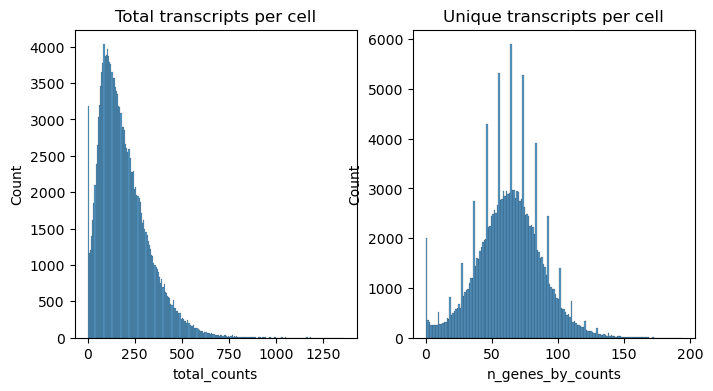

In [13]:
sc.pp.calculate_qc_metrics(xenium, percent_top=(10, 20, 50, 150), inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    xenium.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    xenium.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


In [14]:
# Filter the data
sc.pp.filter_cells(xenium, min_counts=10)
sc.pp.filter_genes(xenium, min_cells=5)

In [21]:
xenium.obs

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,n_genes_by_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_10_genes,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,n_counts
1,1,847.259912,326.191365,28,1,0,28.0,58.387031,26.642187,15,2.772589,3.367296,82.142857,100.000000,100.000000,100.0,28.0
2,2,826.341995,328.031830,94,0,0,94.0,197.016719,42.130781,38,3.663562,4.553877,54.255319,79.787234,100.000000,100.0,94.0
4,4,824.228409,334.252643,11,0,0,11.0,42.311406,10.069844,9,2.302585,2.484907,100.000000,100.000000,100.000000,100.0,11.0
5,5,841.357538,332.242505,48,0,0,48.0,107.652500,37.479687,33,3.526361,3.891820,52.083333,72.916667,100.000000,100.0,48.0
7,7,835.284583,338.135696,10,0,0,10.0,56.851719,17.701250,8,2.197225,2.397895,100.000000,100.000000,100.000000,100.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167776,167776,7455.475342,5114.875415,229,1,0,229.0,220.452812,60.599688,77,4.356709,5.438079,42.794760,63.318777,88.209607,100.0,229.0
167777,167777,7483.727051,5111.477490,79,0,0,79.0,37.389375,25.242344,37,3.637586,4.382027,55.696203,78.481013,100.000000,100.0,79.0
167778,167778,7470.159424,5119.132056,397,0,0,397.0,287.058281,86.700000,75,4.330733,5.986452,55.415617,73.551637,93.702771,100.0,397.0
167779,167779,7477.737207,5128.712817,117,0,0,117.0,235.354375,25.197187,51,3.951244,4.770685,47.863248,69.230769,99.145299,100.0,117.0


Lightwweight data visualization function:

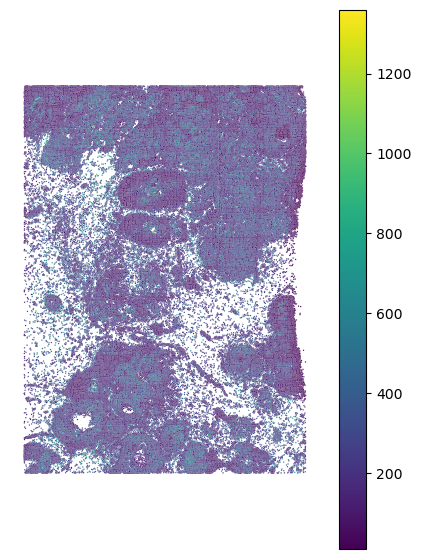

In [23]:
#Visualize the data
sp_plot.plot_xenium(xenium.obs.x_centroid, xenium.obs.y_centroid, 
            xenium.obs.total_counts, palette="viridis")

### 1.2: Run scvi to remove batch effects and prepare data for knn-graph construction

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 42/42: 100%|██████████| 42/42 [05:04<00:00,  7.24s/it, v_num=1, train_loss_step=181, train_loss_epoch=161]

`Trainer.fit` stopped: `max_epochs=42` reached.


Epoch 42/42: 100%|██████████| 42/42 [05:04<00:00,  7.24s/it, v_num=1, train_loss_step=181, train_loss_epoch=161]


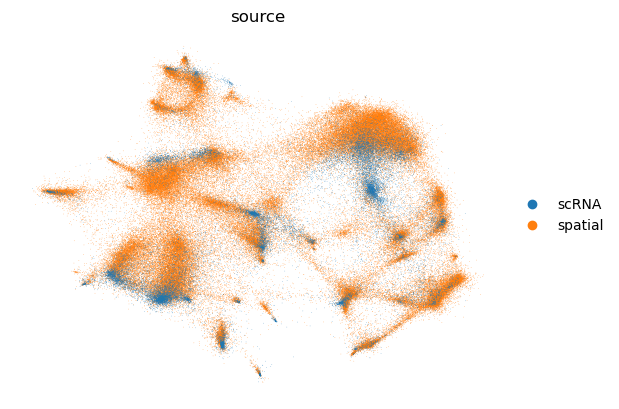

In [24]:
xenium.obs["source"] = "spatial"
adata_ref.obs["source"] = "scRNA"
adata = xenium.concatenate(adata_ref)
cell_source = pp.run_scvi(adata, "../data/res_scvi_xenium.csv")

In [25]:
cell_source.head()

,0,1,source
1-0,1.078594,-0.354043,spatial
2-0,0.826982,-0.345308,spatial
4-0,0.926901,0.060634,spatial
5-0,0.743756,-0.127475,spatial
7-0,0.701196,-0.237537,spatial


In [28]:
cell_source.tail()

,0,1,source
TTTGTGAGTGGTTACT-1,0.708244,1.117670,scRNA
TTTGTGAGTGTTCCAG-1,-0.452168,0.293400,scRNA
TTTGTGAGTTACTTCT-1,0.786309,1.310445,scRNA
TTTGTGAGTTGTCATA-1,0.680145,-0.941370,scRNA
TTTGTGAGTTTGGCCA-1,0.865912,0.308610,scRNA


### 1.3: Construct the knn-graphs

In [29]:
# get rid of the number in the end of the index
cell_source.index = [re.sub(r'-(\d+).*', r'-\1', s) for s in cell_source.index]
emb_spatial =cell_source[cell_source.source == "spatial"][[0,1]]
emb_spatial.index = [x.split("-")[0] for x in emb_spatial.index]
emb_rna = cell_source[cell_source.source == "scRNA"][[0,1]]

In [32]:
print("1. Recording edges between RNA and spatial embeddings...")
# 10 here is the number of neighbors to be considered
edges_sc2xen = pp.record_edges(emb_spatial, emb_rna,10, "sc2xen")
# checking where we have the highest distance to refrence data as those might be potentially problematic spots for mapping
edges_sc2xen = pp.normalize_edge_weights(edges_sc2xen)

print("2. Recording edges between RNA embeddings...")
# 10 here is the number of neighbors to be considered
edges_sc2sc = pp.record_edges(emb_rna,emb_rna, 10, "sc2sc")
edges_sc2sc = pp.normalize_edge_weights(edges_sc2sc)

1. Recording edges between RNA and spatial embeddings...
2. Recording edges between RNA embeddings...


In [33]:
print("3. Creating edges for Visium nodes...")
edges_xen = pp.create_edges_for_xenium_nodes_global(xenium,10)

print("4. Saving edges and embeddings...")
edges = pd.concat([edges_sc2xen, edges_sc2sc, edges_xen])
edges.node1 = edges.node1.astype(str)
edges.node2 = edges.node2.astype(str)

pp.save_edges_and_embeddings(edges, emb_spatial, emb_rna, outdir ="../data/tmp/", suffix="xenium")

3. Creating edges for Visium nodes...
4. Saving edges and embeddings...


In [34]:
edges.head()

,node1,node2,weight,type,distance
0,GATTACCGTGACCTAT-1,1,0.96229,sc2xen,NaN
1,TTTGCGCAGACTCAAA-1,1,0.961565,sc2xen,NaN
2,CCATCCCTCAATCCTG-1,1,0.961372,sc2xen,NaN
3,TATACCTAGTTTACCG-1,1,0.954399,sc2xen,NaN
4,CGTAAACAGTGATTAG-1,1,0.948677,sc2xen,NaN


Make sure that we have 3 types of edges:
- single-cell (reference) to visium `sc2xen`
- visium to visium `xen2grid`
- single-cell (reference) to single-cell (reference) `sc2sc`

In [36]:
edges["type"].unique()

array(['sc2xen', 'sc2sc', 'xen2grid'], dtype=object)

### 1.4: Create the dataset object for pytorch

For the next step we need to convert node IDs and classes (cell types and clones) into numerial values that can be further used by the model 

In [37]:
#annotation file
annotations = adata_ref.obs[["cell_type", "clone"]].copy().reset_index()
annotations.columns = ["node1", "cell_type", "clone"]
annotations.head()

,node1,cell_type,clone
0,AAACAAGCAAACGGGA-1,Stromal,diploid
1,AAACAAGCAAATAGGA-1,Macrophages 1,1
2,AAACAAGCAACAAGTT-1,Perivascular-Like,diploid
3,AAACAAGCAACCATTC-1,Myoepi ACTA2+,1
4,AAACAAGCAACTAAAC-1,Myoepi ACTA2+,4


In [53]:
# first we ensure that there are no missing values and combine annotations with the edges dataframe
edges_enc, annotations_enc = dataset.preprocess_data(edges, annotations,"sc2xen","xen2grid")


In [54]:
edges_enc.head()

,node1,node2,weight,type,distance,clone,cell_type
0,GATTACCGTGACCTAT-1,1,0.962290,sc2xen,NaN,4,DCIS 2
1,TTTGCGCAGACTCAAA-1,1,0.961565,sc2xen,NaN,4,DCIS 2
2,CCATCCCTCAATCCTG-1,1,0.961372,sc2xen,NaN,2,DCIS 1
3,TATACCTAGTTTACCG-1,1,0.954399,sc2xen,NaN,4,DCIS 2
4,CGTAAACAGTGATTAG-1,1,0.948677,sc2xen,NaN,4,DCIS 2


In [55]:
# specify paths to the embeddings that we will use as features for the nodes. Please don't modify unless you previously saved the embeddings in a different location
embedding_paths = {"spatial":f"../data/tmp/embedding_spatial_xenium.csv",
                    "rna":f"../data/tmp/embedding_rna_xenium.csv"}

In [56]:
#next we encode all strings as ingeres and ensure consistancy between the edges and the annotations
emb_xen_nodes, emb_rna_nodes, edges_enc, node_encoder = dataset.read_and_merge_embeddings(embedding_paths, edges_enc)


Excluding 0 clones with less than 10 cells
Excluding 0 cell types with less than 10 cells


In [57]:
edges_enc.head()

,node1,node2,weight,type,distance,clone,cell_type
0,82472,10242,0.962290,sc2xen,NaN,4,DCIS 2
1,93821,10242,0.961565,sc2xen,NaN,4,DCIS 2
2,149960,10242,0.961372,sc2xen,NaN,2,DCIS 1
3,81201,10242,0.954399,sc2xen,NaN,4,DCIS 2
4,7770,10242,0.948677,sc2xen,NaN,4,DCIS 2


In [60]:
#make sure that weight is a float
edges_enc.weight = edges_enc.weight.astype(float)


In [61]:
#Finally creating a pytorch dataset object and a dictionaru that will be used for decoding the data
data, encoding_dict = dataset.create_data_object(edges_enc, emb_vis_nodes, emb_rna_nodes, node_encoder)


In [62]:
torch.save(data, "../data/tmp/data_xenium.pt")
with open('../data/tmp/full_encoding_xenium.pkl', 'wb') as fp:
    pickle.dump(encoding_dict, fp)

## 2: Running spaceTree

### 2.1: Load the data and ID encoder/decoder dictionaries

In [63]:
data = torch.load("../data/tmp/data_xenium.pt")
with open('../data/tmp/full_encoding_xenium.pkl', 'rb') as handle:
    encoder_dict = pickle.load(handle)
node_encoder_rev = {val:key for key,val in encoder_dict["nodes"].items()}
node_encoder_clone = {val:key for key,val in encoder_dict["clones"].items()}
node_encoder_ct = {val:key for key,val in encoder_dict["types"].items()}
data.edge_attr = data.edge_attr.reshape((-1,1))


### 2.2: Separate spatial nodes from reference nodes

In [64]:

hold_out_indices = np.where(data.y_clone == -1)[0]
hold_out = torch.tensor(hold_out_indices, dtype=torch.long)

total_size = data.x.shape[0] - len(hold_out)
train_size = int(0.8 * total_size)

# Get indices that are not in hold_out
hold_in_indices = np.arange(data.x.shape[0])
hold_in = [index for index in hold_in_indices if index not in hold_out]

### 2.3: Create test set from reference nodes

In [65]:
# Split the data into train and test sets
train_indices, test_indices = utils.balanced_split(data,hold_in, size = 0.3)

# Assign the indices to data masks
data.train_mask = torch.tensor(train_indices, dtype=torch.long)
data.test_mask = torch.tensor(test_indices, dtype=torch.long)

# Set the hold_out data
data.hold_out = hold_out

### 2.3: Create weights for the NLL loss to ensure that the model learns the correct distribution of cell types and clones

In [66]:
y_train_type = data.y_type[data.train_mask]
weight_type_values = utils.compute_class_weights(y_train_type)
weight_type = torch.tensor(weight_type_values, dtype=torch.float)
y_train_clone = data.y_clone[data.train_mask]
weight_clone_values = utils.compute_class_weights(y_train_clone)
weight_clone = torch.tensor(weight_clone_values, dtype=torch.float)
data.num_classes_clone = len(data.y_clone.unique())
data.num_classes_type = len(data.y_type.unique())

### 2.4: Create Neigborhor Loader for efficient training

In [67]:
del data.edge_type

train_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 3,
    batch_size=128,input_nodes = data.train_mask
)

valid_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 3,
    batch_size=128,input_nodes = data.test_mask
)

### 2.5: Specifying the device and sending the data to the device

In [68]:
device = torch.device('cuda:0')
data = data.to(device)
weight_clone =  weight_clone.to(device)
weight_type = weight_type.to(device)
data.num_classes_clone = len(data.y_clone.unique())
data.num_classes_type = len(data.y_type.unique())


### 2.6: Model specification and training

In [69]:
lr = 0.01
hid_dim = 100
head = 2
wd = 0.001
model = GATLightningModule_sampler(data, 
                                   weight_clone, weight_type, learning_rate=lr, 
                                   heads = head, dim_h = hid_dim, weight_decay= wd)
model = model.to(device)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="validation_combined_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
trainer1 = pl.Trainer(max_epochs=1000, accelerator = "gpu", devices = [0],
                    callbacks = [early_stop_callback], 
                    log_every_n_steps=10)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
trainer1.fit(model, train_loader, valid_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type | Params
-------------------------------
0 | model | GAT2 | 55.9 K
-------------------------------
55.9 K    Trainable params
0         Non-trainable params
55.9 K    Total params
0.224     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 151/151 [00:01<00:00, 79.98it/s, v_num=1, validation_acc_clone=0.663, validation_acc_ct=0.616, validation_combined_loss=0.000856, train_combined_loss=1.540]

Metric validation_combined_loss improved. New best score: 0.001


Epoch 2: 100%|██████████| 151/151 [00:01<00:00, 79.97it/s, v_num=1, validation_acc_clone=0.679, validation_acc_ct=0.673, validation_combined_loss=0.000735, train_combined_loss=1.160] 

Metric validation_combined_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Epoch 12: 100%|██████████| 151/151 [00:01<00:00, 89.75it/s, v_num=1, validation_acc_clone=0.711, validation_acc_ct=0.725, validation_combined_loss=0.000632, train_combined_loss=1.010] 

Metric validation_combined_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Epoch 22: 100%|██████████| 151/151 [00:01<00:00, 86.02it/s, v_num=1, validation_acc_clone=0.715, validation_acc_ct=0.730, validation_combined_loss=0.000607, train_combined_loss=0.994] 

Monitored metric validation_combined_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 151/151 [00:01<00:00, 85.77it/s, v_num=1, validation_acc_clone=0.715, validation_acc_ct=0.730, validation_combined_loss=0.000607, train_combined_loss=0.994]



In [71]:
# Predction on spatial data
model.eval()
model = model.to(device)
with torch.no_grad():
    out, w, _ = model(data)

In [80]:
# Decoding the results back to the original format
clone_res,ct_res= utils.get_calibrated_results(out, data, node_encoder_rev, node_encoder_ct,node_encoder_clone, 1)

## 3: Results and visualization

In [81]:
clone_res["clone"] = clone_res.idxmax(axis=1)
ct_res["cell_type"] = ct_res.idxmax(axis=1)

In [82]:
xenium.obs = xenium.obs.join(clone_res[["clone"]]).join(ct_res[["cell_type"]])
xenium.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,n_genes_by_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_10_genes,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,n_counts,source,clone,cell_type
1,1,847.259912,326.191365,28,1,0,28.0,58.387031,26.642187,15,2.772589,3.367296,82.142857,100.000000,100.0,100.0,28.0,spatial,4,DCIS 2
2,2,826.341995,328.031830,94,0,0,94.0,197.016719,42.130781,38,3.663562,4.553877,54.255319,79.787234,100.0,100.0,94.0,spatial,4,DCIS 2
4,4,824.228409,334.252643,11,0,0,11.0,42.311406,10.069844,9,2.302585,2.484907,100.000000,100.000000,100.0,100.0,11.0,spatial,4,DCIS 2
5,5,841.357538,332.242505,48,0,0,48.0,107.652500,37.479687,33,3.526361,3.891820,52.083333,72.916667,100.0,100.0,48.0,spatial,4,DCIS 2
7,7,835.284583,338.135696,10,0,0,10.0,56.851719,17.701250,8,2.197225,2.397895,100.000000,100.000000,100.0,100.0,10.0,spatial,4,DCIS 2


### 3.1: Clon mapping
First we will visualize the clone mapping results and compare them to the histological annotation provided by the authors:
<div style="text-align: left;">
  <a href="https://raw.githubusercontent.com/PMBio/spaceTree/master/docs/histo.png" download>
    <img src="https://raw.githubusercontent.com/PMBio/spaceTree/master/docs/histo.png" alt="histo" width="200"/>
  </a>
</div>
(note that the images are not fully overlapping)

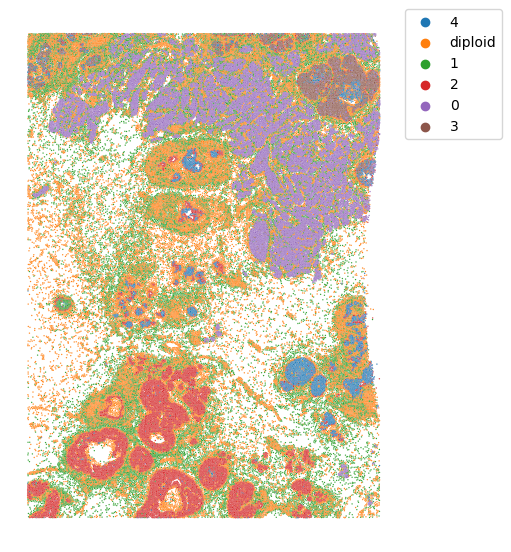

In [83]:
sp_plot.plot_xenium(xenium.obs.x_centroid, xenium.obs.y_centroid, 
            xenium.obs.clone)

We can see that invasive tumor alligns with clone 0, DCIS 1 with clone 2, DCIS 2 with clone 3 (top part) and 4 (right part).
Interestingly, that DCIS 2 was separated into two clones with distinct spatial locations. Indeed, despite being classified as a single DCIS, those clones have distinct CNV patterns (e.g. chr3 and chr19):
<div style="text-align: left;">
  <a href="https://raw.githubusercontent.com/PMBio/spaceTree/master/docs/cnv_map.png" download>
    <img src="https://raw.githubusercontent.com/PMBio/spaceTree/master/docs/cnv_map.png" alt="histo" width="2000"/>
  </a>
</div>

(the image is taken from `../docs//infercnv_run.ipynb`)

Moreover: the clonal mapping perfectly alligns to the one obtained from Visium [spaceTree tutorial](https://pmbio.github.io/spaceTree/) despite vast differences in the data types and resolution.
<div style="text-align: left;">
  <a href="https://github.com/PMBio/spaceTree/blob/master/docs/tutorials/cell-state-clone-mapping_files/cell-state-clone-mapping_55_0.png?raw=true" download>
    <img src="https://github.com/PMBio/spaceTree/blob/master/docs/tutorials/cell-state-clone-mapping_files/cell-state-clone-mapping_55_0.png?raw=true" alt="histo" width="2000"/>
  </a>
</div>


Cell types can be visualized in the same way:

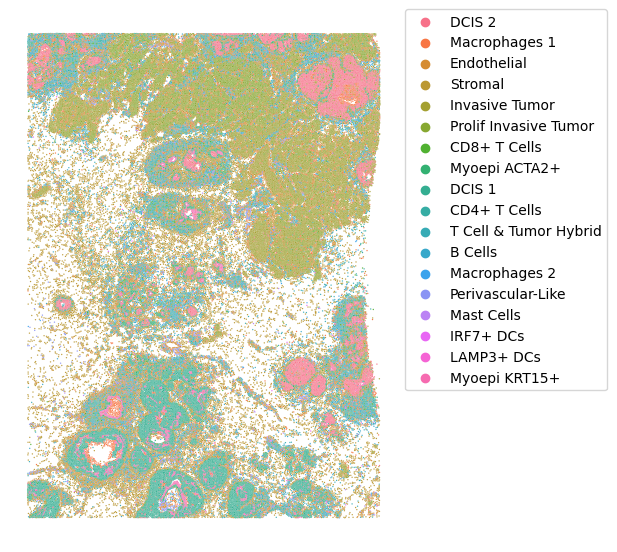

In [84]:
sp_plot.plot_xenium(xenium.obs.x_centroid, xenium.obs.y_centroid, 
            xenium.obs.cell_type)